In [2]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import gpplot as gpp
import numpy as np
from scipy import stats
from poola import core as pool
gpp.set_aesthetics()
import warnings
warnings.filterwarnings("ignore")

# Importing data

In [14]:
read_counts = pd.read_csv('../../required_data/Primary Screen/counts-A549_CP1986_CP1987.txt', sep='\t')
read_counts = read_counts.rename({'Construct Barcode': 'sgrna_sequence'}, axis = 1)

In [15]:
annotations = pd.read_csv('../../required_data/Primary screen/BE_splice_libs_filtered_ann.csv')[['sgRNA Sequence','set']]
annotations = annotations.rename({'sgRNA Sequence': 'sgrna_sequence'}, axis = 1)
annotations = (annotations[annotations['set'].str.contains('guide')]).reset_index(drop = True)
annotations = annotations.drop_duplicates().reset_index(drop = True)

In [16]:
CBE_condition_list =['A549_RDB092_CP1987A_CP1989A',
                    'A549_RDB092_CP1987A_CP1989B',
                    'A549_RDB092_CP1987B_CP1989A',
                    'A549_RDB092_CP1987B_CP1989B',
                    'A549_RDB096_CP1987A_CP1989A',
                    'A549_RDB096_CP1987A_CP1989B',
                    'A549_RDB096_CP1987B_CP1989A',
                    'A549_RDB096_CP1987B_CP1989B',
                    'CP1987_pDNA']

In [17]:
#adding in annotations
ann_reads = annotations.merge(read_counts, on= 'sgrna_sequence')

# Filtering

In [18]:
#dropping all ABE guides from list
reads = (ann_reads[ann_reads['set'] == 'CBE_guide_set1']).reset_index(drop = True)

In [19]:
#calculating lognorms
lognorms = pool.lognorm_columns(reads_df=reads, columns=['A549_RDB092_CP1987A_CP1989A',
                    'A549_RDB092_CP1987A_CP1989B',
                    'A549_RDB092_CP1987B_CP1989A',
                    'A549_RDB092_CP1987B_CP1989B',
                    'A549_RDB096_CP1987A_CP1989A',
                    'A549_RDB096_CP1987A_CP1989B',
                    'A549_RDB096_CP1987B_CP1989A',
                    'A549_RDB096_CP1987B_CP1989B',
                    'CP1987_pDNA'])

In [20]:
filtered_lognorms = pool.filter_pdna(lognorm_df=lognorms, pdna_cols=['CP1987_pDNA'], z_low=-3)
print('Filtered ' + str(reads.shape[0] - filtered_lognorms.shape[0]) + ' columns due to low pDNA abundance')

Filtered 3 columns due to low pDNA abundance


We'll only be continuing with RDB092 (TadCBEd) given previous experiments (Fig 1f).

In [21]:
lfc_df_temp = pool.calculate_lfcs(lognorm_df=filtered_lognorms, ref_col='CP1987_pDNA', target_cols=['A549_RDB092_CP1987A_CP1989A',
                                                                                        'A549_RDB092_CP1987A_CP1989B',
                                                                                        'A549_RDB092_CP1987B_CP1989A',
                                                                                        'A549_RDB092_CP1987B_CP1989B',
                                                                                        'A549_RDB096_CP1987A_CP1989A',
                                                                                        'A549_RDB096_CP1987A_CP1989B',
                                                                                        'A549_RDB096_CP1987B_CP1989A',
                                                                                        'A549_RDB096_CP1987B_CP1989B',])

lfc_df = lfc_df_temp[['sgrna_sequence','A549_RDB092_CP1987A_CP1989A',
                    'A549_RDB092_CP1987A_CP1989B',
                    'A549_RDB092_CP1987B_CP1989A',
                    'A549_RDB092_CP1987B_CP1989B']]
                    
lfc_df = lfc_df.set_index("sgrna_sequence")

In [22]:
lfc_df_2 = lfc_df.rename(columns={"A549_RDB092_CP1987A_CP1989A": "TadCBEd SGL rep A +\n" "STL rep A",
                                "A549_RDB092_CP1987A_CP1989B": "TadCBEd SGL rep A +\n" "STL rep B",
                                "A549_RDB092_CP1987B_CP1989A": "TadCBEd SGL rep B +\n" "STL rep A",
                                "A549_RDB092_CP1987B_CP1989B": "TadCBEd SGL rep B +\n" "STL rep B"})

In [23]:
lfc_df_2 = lfc_df_2.reindex(sorted(lfc_df_2.columns), axis=1)

## Replicate correlation heatmaps

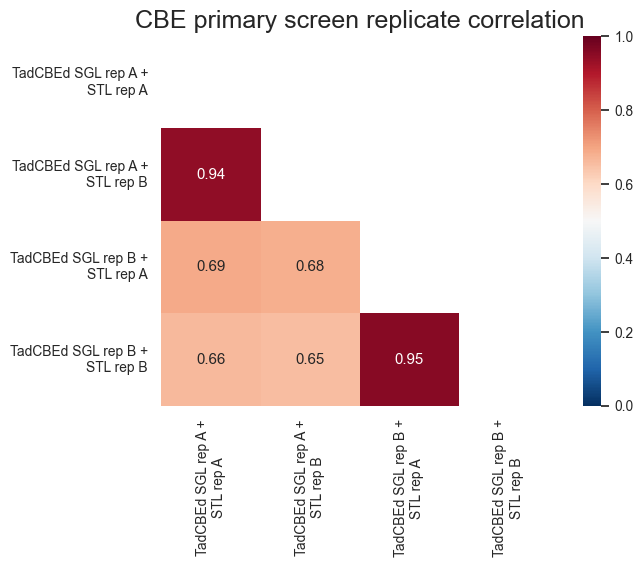

In [24]:
sns.set(font_scale=0.9)
sns.set_style(rc = {'axes.facecolor': 'white'})

lfc_correlations = lfc_df_2.corr()
matrix = np.triu(lfc_correlations)

sns.heatmap(lfc_correlations, cmap='RdBu_r',
               vmin=0, vmax=1, annot=True, mask=matrix)
t = plt.title('CBE primary screen replicate correlation', x=0.5, fontsize=18)

## Calculate z-scores

In [25]:
cbe_lfcs_2 = lfc_df.reset_index().copy()
cbe_lfcs_2 = cbe_lfcs_2[['sgrna_sequence','A549_RDB092_CP1987A_CP1989A','A549_RDB092_CP1987A_CP1989B',
                         'A549_RDB092_CP1987B_CP1989A','A549_RDB092_CP1987B_CP1989B']]
cbe_lfcs_long = pd.melt(cbe_lfcs_2, id_vars=['sgrna_sequence'], value_vars=['A549_RDB092_CP1987A_CP1989A',
                                                                            'A549_RDB092_CP1987A_CP1989B',
                                                                            'A549_RDB092_CP1987B_CP1989A',
                                                                            'A549_RDB092_CP1987B_CP1989B'])
#get mean and sd to z score
cbe_mean = cbe_lfcs_long['value'].mean()
cbe_sd = cbe_lfcs_long['value'].std()

#find average lfc per guide + z score it
cbe_lfcs_2 = cbe_lfcs_2.set_index('sgrna_sequence')
cbe_lfcs_2['avg'] = cbe_lfcs_2.mean(axis=1)
cbe_lfcs_2['avg_z'] = (cbe_lfcs_2['avg'] - cbe_mean) / cbe_sd

#rank by average lfc Z score
cbe_lfcs_2 = cbe_lfcs_2.sort_values(by = 'avg_z', ascending = False).reset_index(drop = False)
cbe_lfcs_2['rank'] = cbe_lfcs_2.index + 1

#long form
cbe_lfcs_long = pd.melt(cbe_lfcs_2, id_vars=['sgrna_sequence','avg','avg_z','rank'], value_vars=['A549_RDB092_CP1987A_CP1989A',
                                                                            'A549_RDB092_CP1987A_CP1989B',
                                                                            'A549_RDB092_CP1987B_CP1989A',
                                                                            'A549_RDB092_CP1987B_CP1989B'])
cbe_lfcs_long['z-score_per_rep'] = (cbe_lfcs_long['value'] - cbe_mean) / cbe_sd

#nominate guides based on per replicate z>2
cbe_lfcs_long['Nominated'] = np.where(cbe_lfcs_long['z-score_per_rep'] >1.96, 'Nominated','Not nominated')
validation_nominated_sgrnas = cbe_lfcs_long[cbe_lfcs_long['Nominated']=='Nominated']['sgrna_sequence'].unique()

array(['CAGGCGGGTAAGGTTCTCGG', 'CAGGCGGGTAGACTAACCGG',
       'CAGGCGGGTATAAAGTGCGG', 'CAGGCGTGTAACTTGAACGG',
       'CAGGCGGGTATAGATACCGG'], dtype=object)

In [27]:
cbe_lfcs_2['Nominated'] = np.where(cbe_lfcs_2['sgrna_sequence'].isin(validation_nominated_sgrnas), 'Nominated','Not nominated')

cbe_lfcs_max = cbe_lfcs_2.set_index('sgrna_sequence')
cbe_lfcs_max = cbe_lfcs_max.drop(['Nominated', 'rank', 'avg_z'], axis=1)
cbe_lfcs_max['lfc_max'] = cbe_lfcs_max.max(axis=1)

cbe_lfcs_max['max_z'] = (cbe_lfcs_max['lfc_max'] - cbe_mean) / cbe_sd

cbe_lfcs_max['max rank'] = cbe_lfcs_max['max_z'].rank(ascending=False)
cbe_lfcs_max = cbe_lfcs_max.sort_values(by=['max rank'])

In [28]:
cbe_lfcs_max = cbe_lfcs_max.reset_index(drop=False)
cbe_lfcs_max = pd.merge(cbe_lfcs_max,cbe_lfcs_2[['sgrna_sequence', 'Nominated']],on='sgrna_sequence', how='left')

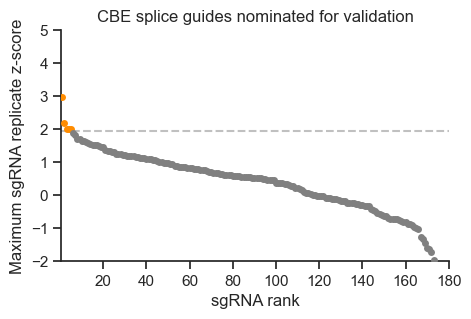

In [29]:
#maximum zscore as rank, highlighting nominated guides
gpp.set_aesthetics()

fig, ax = plt.subplots(figsize=(5,3))

colors={'Nominated': 'darkorange', 'Not nominated':'gray'}

s = sns.stripplot(x='max rank', y='max_z', data=cbe_lfcs_max,size =5, hue = 'Nominated', palette = colors, legend=False)

plt.axhline(y=1.96, color = 'silver', linestyle = '--')
    
plt.xticks(ticks=range(19,180,20), labels=(20, 40, 60, 80, 100, 120, 140, 160, 180))
ax.set_xlabel('sgRNA rank')
ax.set_ylabel('Maximum sgRNA replicate z-score')
t = plt.title('CBE splice guides nominated for validation')
ax.set_ylim(-2, 5)


sns.despine()